In [1]:
# install.packages("tidymodels")
# install.packages("infer")
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(tidymodels))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(infer))
suppressPackageStartupMessages(library(GGally))
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 6, repr.plot.height = 6)
set.seed(100)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


## Climate Change: Study temperature and precipitation in historical vs contemporary weather records   
**STAT 201  Project Proposal - Group 17  
Date:         March 03, 2022**

## Introduction

Climate change refers to long-term shifts in temperatures and weather patterns (United Nations, n.d.-b). The Canadian Climate and Weather Database provides weather records from numerous weather stations across Canada. Each weather station contains weather records in hourly, daily, and monthly formats. We intend to study the presence of climate change from some historical years to the present. In order to obtain a meaningful and relatively large time span, the group queried stations with data available between 1950 and 2022. From the 8796 weather stations, the group randomly selected **ABBOTSFORD A** weather station to use for this study (Historical Data, 2021, November 25).

The group chooses daily temperature and daily precipitation as the random variable across two categories - historical vs contemporary. In both variables, the group chooses to study the parameter mean. We believe that the difference in mean in daily temperature and precipitation can aid us to study the claimed effect of climate change: hotter temperature and increased drought (United Nations, n.d.-a). Thus, this project aims to answer:
  
- Is there a significant difference in the weather record of the 1950s and the 2000s in terms of temperature and precipitation? 


## Preliminary Results

### Data Importing, Cleaning, and Wrangling
  
We first downloaded and imported daily data from 1951 to 1955 and 2001 to 2005.

In [2]:
climate_1951 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_1951_P1D.csv", show_col_types = FALSE)
climate_1952 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_1952_P1D.csv", show_col_types = FALSE)
climate_1953 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_1953_P1D.csv", show_col_types = FALSE)
climate_1954 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_1954_P1D.csv", show_col_types = FALSE)
climate_1955 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_1955_P1D.csv", show_col_types = FALSE)
climate_2001 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_2001_P1D.csv", show_col_types = FALSE)
climate_2002 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_2002_P1D.csv", show_col_types = FALSE)
climate_2003 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_2003_P1D.csv", show_col_types = FALSE)
climate_2004 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_2004_P1D.csv", show_col_types = FALSE)
climate_2005 <- read_csv("https://raw.githubusercontent.com/yxing6/STAT201-GroupProject-Climate/main/Data/en_climate_daily_BC_1100030_2005_P1D.csv", show_col_types = FALSE)


Next, we combined the yearly data and mutated a column to indicate the recorded time. The data in the 1951-1955 are labeled as `historical` and 2001-2005 as `contemporary`. We further combined these two data frames to serve as the raw sample for this study.
      
The raw sample contains 31 variables of weather measurements in which we decided to use the following as our possible parameters: 
- `Year`: the year of the weather record 
- `Mean Temp`: average temperature of the day in degrees Celsius
- `Total Precip`: total amount of precipitation measured in millimetres. 
  
The following codes demonstrate the steps of data cleaning and wrangling:


In [3]:
climate_historical <- 
    rbind(climate_1951, climate_1952, climate_1953, climate_1954, climate_1955) %>%
    mutate(Category = as.factor("historical"))

climate_contemporary <- 
    rbind(climate_2001, climate_2002, climate_2003, climate_2004, climate_2005) %>%
    mutate(Category = as.factor("contemporary"))

climate_merge <- rbind(climate_historical, climate_contemporary) 

In [4]:
climate_sample <- climate_merge %>%
    select(Category, Year, "Mean Temp (°C)", "Total Precip (mm)") %>%
    rename("Mean_Temp" = "Mean Temp (°C)",
           "Total_Precip" = "Total Precip (mm)")
head(climate_sample)

Category,Year,Mean_Temp,Total_Precip
<fct>,<dbl>,<dbl>,<dbl>
historical,1951,3.6,21.3
historical,1951,3.6,32.0
historical,1951,4.2,1.3
historical,1951,-0.3,0.0
historical,1951,0.8,0.0
historical,1951,2.3,0.0


*Table 1. Table of sample weather record at Abbotsford A weather station.*

### Preliminary Data Explore - Temperature

United Nations (n.d.-b) states that the temperature in the recent decade is higher than last century. We visualized the temperature change with a boxplot.

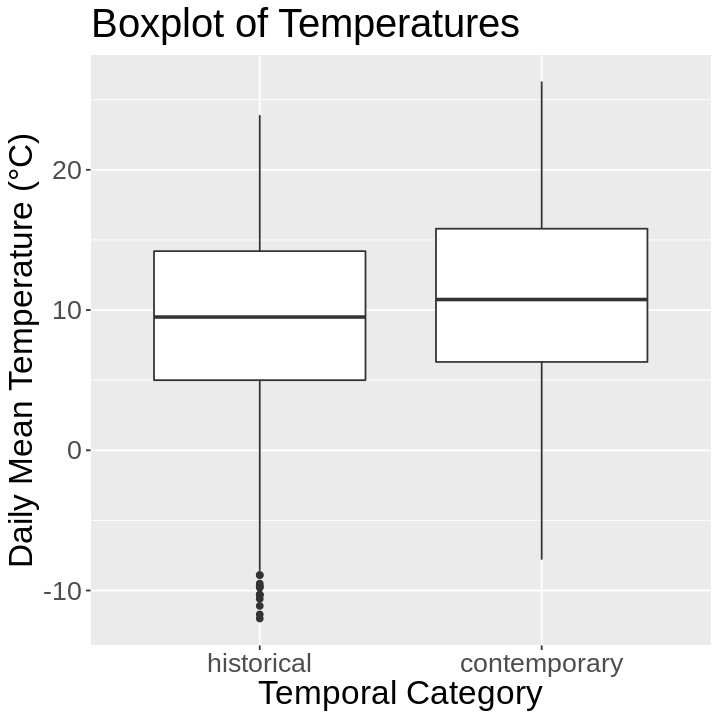

In [5]:
station_temp <- climate_sample %>%
    filter(!is.na(Mean_Temp)) %>%
    select(Category, Mean_Temp)

temp_boxplot <- station_temp %>%
    ggplot(aes(x = Category, y = Mean_Temp)) +
    geom_boxplot() +
    labs(x = "Temporal Category", y = "Daily Mean Temperature (°C)") +
    ggtitle("Boxplot of Temperatures") +
    theme(text = element_text(size = 20))
temp_boxplot

*Figure 1. Boxplot of daily mean temperature at Abbotsford A weather station*

From this boxplot, we can observe that there is a small difference in the mean of daily `Mean_Temp` between the historical and contemporary weather records. However, is there a ***real*** difference in the mean of the daily temperature? We answer this question by bootstrapping.

### Bootstrapping for Point Estimates - Temperature

We first visualized the sample distribution. 

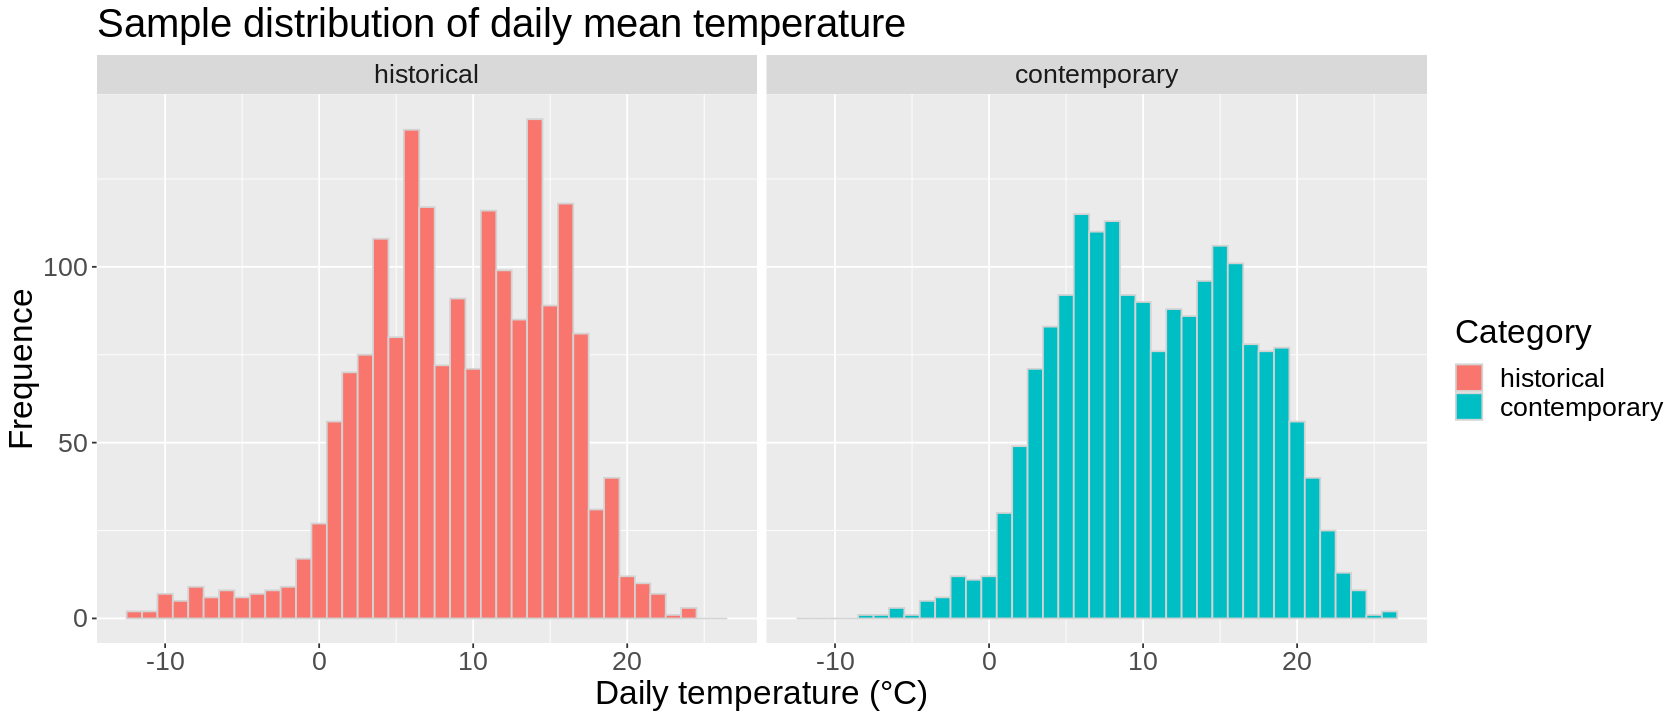

In [6]:
options(repr.plot.width = 14, repr.plot.height = 6)

station_temp_sample_distribution <- station_temp %>%
    ggplot(aes(x = Mean_Temp, fill = Category)) +
    geom_histogram(binwidth = 1, color = "lightgrey") +
    facet_grid(. ~ Category) +
    labs(x = "Daily temperature (°C)", y = "Frequence") +
    ggtitle("Sample distribution of daily mean temperature") +
    theme(text = element_text(size = 20))
station_temp_sample_distribution   

*Figure 2. Sample distribution of daily mean temperature at Abbotsford A weather station.*

We then used a bootstrap distribution to estimate the standard error in the point estimate and generated a 95% confidence interval for each point estimate. 

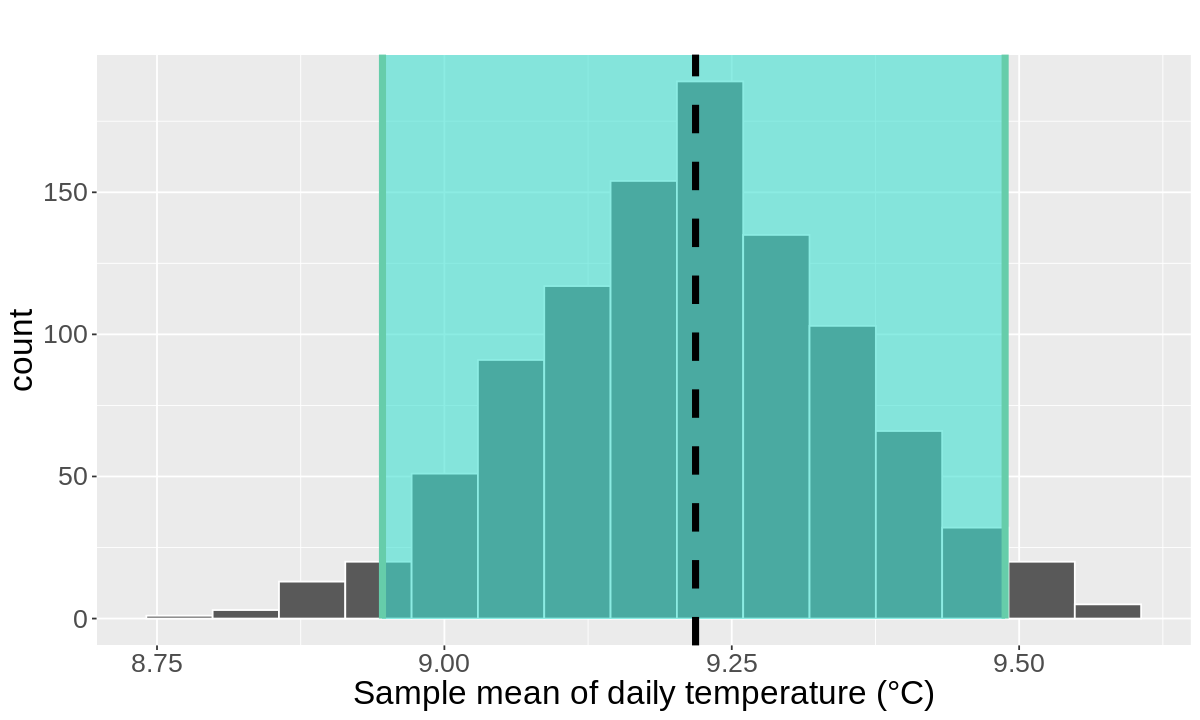

In [7]:
options(repr.plot.width = 10, repr.plot.height = 6)
set.seed(100)

temp_historical <- station_temp %>%
    filter(Category == "historical")

temp_historical_mean <- temp_historical %>%
    summarize(mean = mean(Mean_Temp)) %>%
    pull()

temp_historical_bootstrap <- temp_historical %>%
    specify(response = Mean_Temp) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "mean")

temp_historical_percentile_ci <- temp_historical_bootstrap %>%
    get_ci(level = 0.95, type = "percentile")

visualize(temp_historical_bootstrap, binwidth = 0.05) +
    shade_ci(endpoints = temp_historical_percentile_ci) +
    labs(title = "", x = "Sample mean of daily temperature (°C)") +
    geom_vline(xintercept = temp_historical_mean, size = 2, linetype = "dashed") +
    theme(text = element_text(size = 20))

*Figure 3. Bootstrap distribution of the historical sample means with 95% confidence interval.*

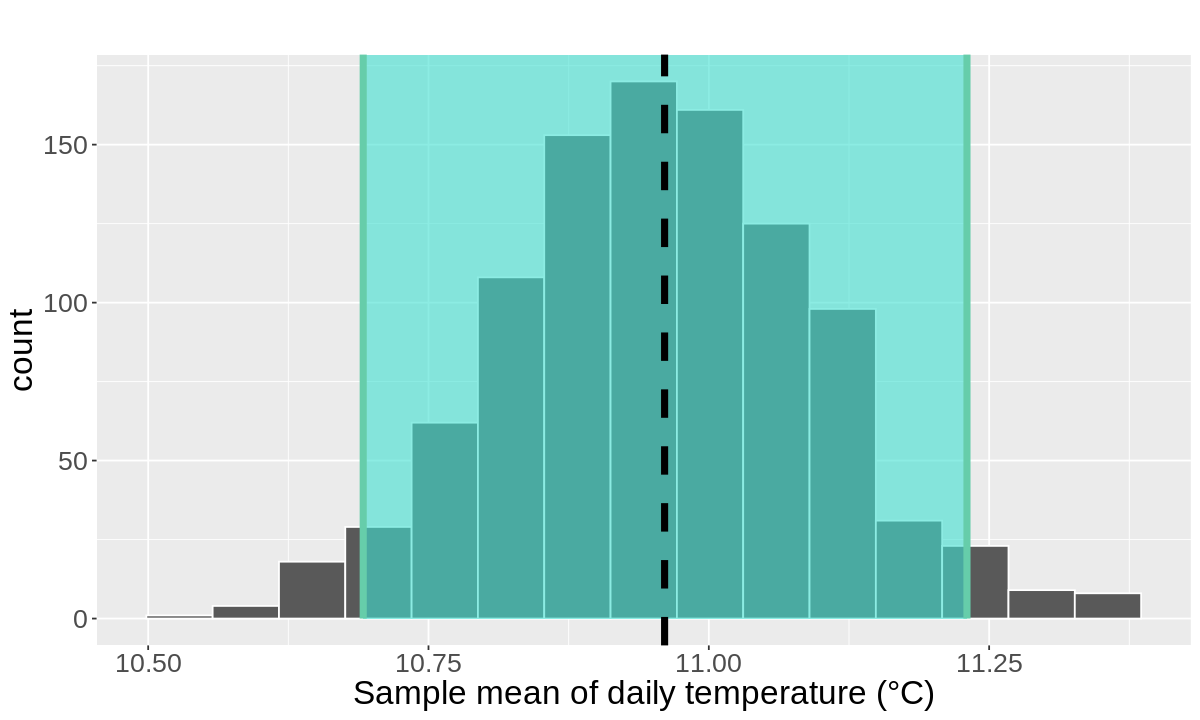

In [8]:
set.seed(100)
options(repr.plot.width = 10, repr.plot.height = 6)

temp_contemporary <- station_temp %>%
    filter(Category == "contemporary")

temp_contemporary_mean <- temp_contemporary %>%
    summarize(mean = mean(Mean_Temp)) %>%
    pull()

temp_contemporary_bootstrap <- temp_contemporary %>%
    specify(response = Mean_Temp) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "mean")

temp_contemporary_percentile_ci <- temp_contemporary_bootstrap %>%
    get_ci(level = 0.95, type = "percentile")

visualize(temp_contemporary_bootstrap, binwidth = 0.05) +
    shade_ci(endpoints = temp_contemporary_percentile_ci) +
    labs(title = "", x = "Sample mean of daily temperature (°C)") +
    geom_vline(xintercept = temp_contemporary_mean, size = 2, linetype = "dashed") +
    theme(text = element_text(size = 20))

*Figure 4. Bootstrap distribution of the contemporary sample means with 95% confidence interval.*

Table 2 summarizes the point estimate for each category and reports their 95% confidence interval. 

| Category    | Point Estimate $\bar{x}$  |  Lower CI  |  Upper CI
| :----------: | :----------: | :----------: |:----------:|
| historical|9.22|8.95|9.49
| contemporary|10.96|10.69|11.23

<center><i>Table 2. Table of the estimates for daily mean temperature.</i>    

And we interpret this as:
- If we repeated our sampling procedure a large number of times, we expect about 95% of the confidence intervals [8.95, 9.49] to capture the value of the population parameter $\mu$ - the mean of daily temperature from 1951 to 1955.  
- If we repeated our sampling procedure a large number of times, we expect about 95% of the confidence intervals [10.69, 11.23] to capture the value of the population parameter $\mu$ - the mean of daily temperature from 2001 to 2005. 

### Hypothesis Testing - Temperature

Our initial hypothesis testing is conducted using simulation based permutation with the `infer` package. We chose a significant value of $\alpha$ = 0.05 as a standard value in the statistics field. Although this might change as we progress further into the project.  
We first calculated the observed test statistic, then generated a simulation from the null distribution. We further obtained the P-value. The following codes demonstrate the steps:

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


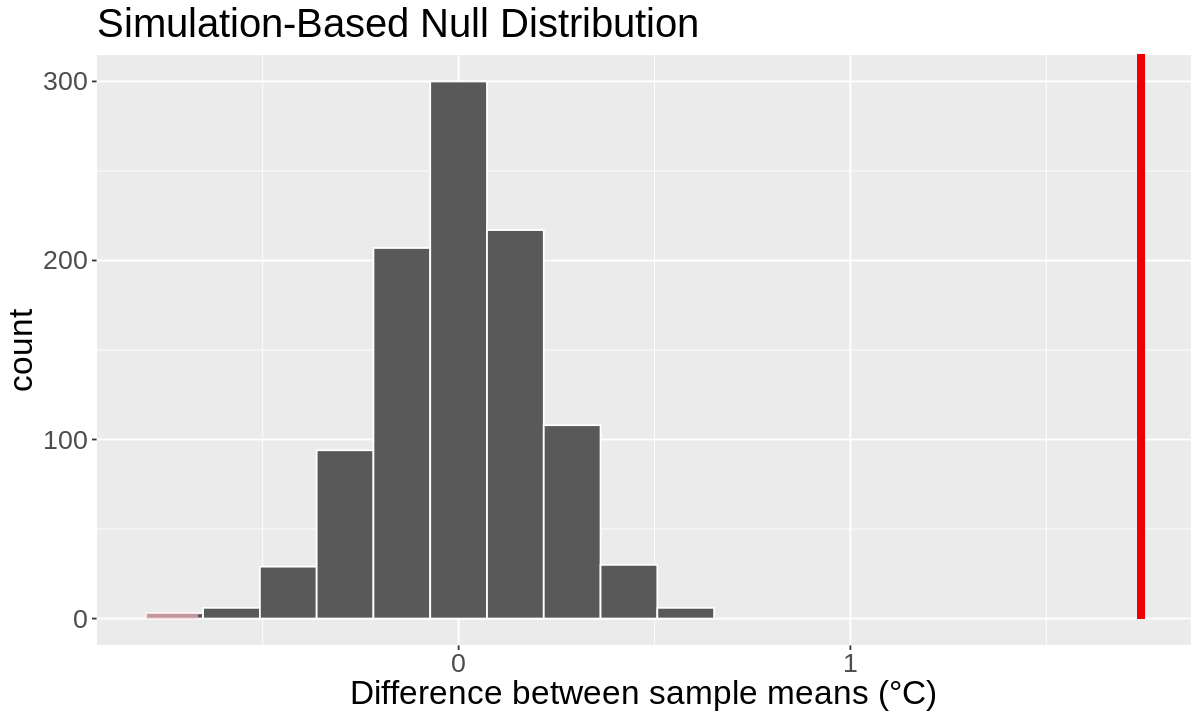

In [9]:
set.seed(100)
options(repr.plot.width = 10, repr.plot.height = 6)

obs_diff_in_temp <- station_temp %>%
    specify(formula = Mean_Temp ~ Category) %>%
    calculate(stat = "diff in means", order = c("contemporary", "historical"))

null_diff_in_temp <- station_temp %>%
    specify(formula = Mean_Temp ~ Category) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("contemporary", "historical"))

diff_in_temp_plot <- null_diff_in_temp %>%
    visualize(bins = 10) +
    shade_p_value(obs_stat = obs_diff_in_temp, direction = "both") +
    xlab("Difference between sample means (°C)") +
    theme(text = element_text(size = 20))
diff_in_temp_plot

p_value <- null_diff_in_temp %>%
    get_p_value(obs_stat = obs_diff_in_temp, direction = "both")

*Figure 5. Figure of simulation distribution and P-value of daily temperature hypothesis test.*

Notice that simulation returned a p-value of 0; however, we should never report a p-value of 0 because this suggests that making a Type I error is impossible. Since we used 1000 reps to calculate the sample, we conclude:  
**The p-value is < 0.001, we reject the null hypothesis $H_0$ in favor of $H_A$ at the 5% significant level.**

We further computed the confidence interval of this test statistic with a 95% confidence interval.

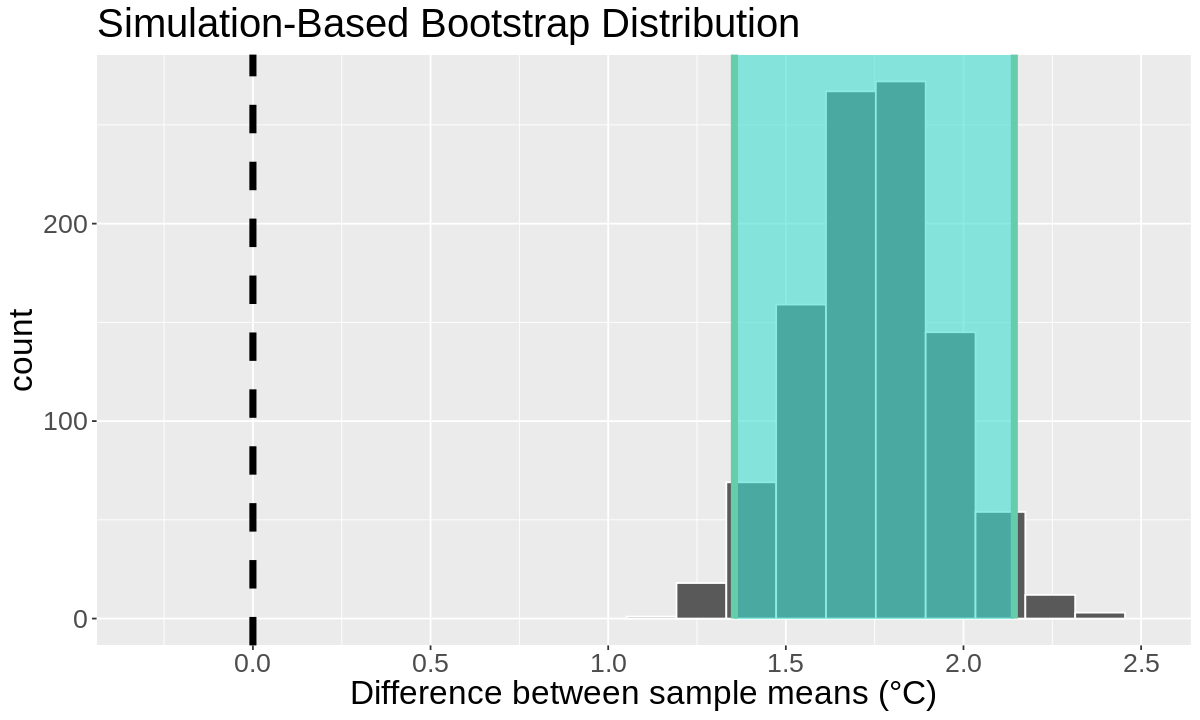

In [10]:
options(repr.plot.width = 10, repr.plot.height = 6)
set.seed(100)
diff_in_temp_bootstrap_dist <- station_temp %>%
    specify(formula = Mean_Temp ~ Category) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("contemporary", "historical"))

diff_in_temp_ci <- 
     diff_in_temp_bootstrap_dist %>% 
     get_confidence_interval(level = 0.95, type = "percentile")

diff_in_temp_ci_plot <- diff_in_temp_bootstrap_dist %>%
    visualize(bins = 10) +
    shade_ci(diff_in_temp_ci) +
    xlab("Difference between sample means (°C)") +
    scale_x_continuous(limits = c(-0.3, 2.5)) +
    geom_vline(xintercept = 0, size = 2, linetype = "dashed") +
    theme(text = element_text(size = 20))
diff_in_temp_ci_plot

*Figure 6. Figure of simulated bootstrap distribution of confidence interval of sample statistic.*

Notice that the value 0 is not included in our confidence interval, again suggesting that $\bar{x}_{contemporary}$ and $\bar{x}_{historical}$ are truly different.  

Table 3 summarizes the value we obtained for this test statistic.  95% confidence interval. 

| Test Statistic    | Observed Test Statistic |  p-value | Lower CI  |  Upper CI
| :----------: | :----------: | :----------: |:----------:| :---------:|
| $\bar{x}_{contemporary}$ - $\bar{x}_{historical}$|1.74 | <0.001|1.36|2.14|

<center><i>Table 3. Table of the estimates for test statistic difference in mean temperature.</i>

## Methods - Plan

This study wishes to verify the claim of climate change effect from our weather record sample. Moving forward, the group intends to perform a similar analysis on precipitation data. At the first glance, we noticed that the majority of the values in the precipitation variable are zero, which brings the point estimate of the sample mean to a minimal level (close to zero) for both historical and contemporary categories. How to better utilize this dataset will be the next task the group plans to focus on. The group also plans to investigate the asymptotics method as a comparison to the simulation-based method for all the estimates.  
  
This study serves as an empirical analysis of climate change for the Abbotsford region and may impact how the municipalities plan to adjust their local agriculture industry facing the rising temperature and drought situation in the future.  
  
Can our study be generalized to a broader population outside of the Abbotsford region? What other dataset do we need to include for such generalization to be valid and meaningful? These are the questions for future studies to focus on. 

## Reference
  
Historical Data. (2021, November 25), Government of Canada, weather, climate and hazards. https://climate.weather.gc.ca/historical_data/search_historic_data_e.html  
  
United Nations. (n.d.-a), Causes and effects of climate change
https://www.un.org/en/climatechange/science/causes-and-effects-of-climate-change  

United Nations. (n.d.-b), What is climate change? https://www.un.org/en/climatechange/what-is-climate-change  

